In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, f1_score, fbeta_score
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [2]:
sepsis_df = pd.read_pickle("../data/sepsis_df_median_imputed.pkl")

# create X and y for model
X = sepsis_df.drop(columns=['isSepsis'])
y = sepsis_df.isSepsis

In [3]:
# splitting into train, val, test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=248)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=248)

In [4]:
# very imbalanced dataset, needs resampling!
from collections import Counter
Counter(y_train)

Counter({0: 21519, 1: 1713})

In [5]:
# resampling using SMOTE
from imblearn.over_sampling import SMOTE

X_train, y_train = SMOTE(random_state=42).fit_resample(X_train,y_train)

In [6]:
# resampling using random oversampling
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)

X_train, y_train = ros.fit_resample(X_train,y_train)

In [7]:
Counter(y_train)

Counter({0: 21519, 1: 21519})

In [8]:
from sklearn.metrics import make_scorer
# creating a new scoring metric that uses beta = 2
f_beta_2 = make_scorer(fbeta_score, beta=2)

In [9]:
def scores(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    fbeta = fbeta_score(y_true, y_pred, beta=2)

    print(f'Accuracy score: {accuracy}')
    print(f'Precision score: {precision}')
    print(f'Recall: {recall}')
    print(f'F1: {f1}')
    print(f'F-beta (beta=2): {fbeta}')

In [10]:
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_val)[:, 1] >= threshold)
    sepsis_confusion = confusion_matrix(y_val, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(sepsis_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['No Sepsis', 'Sepsis'],
           yticklabels=['No Sepsis', 'Sepsis']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

In [21]:
rf = RandomForestClassifier(n_estimators=130)
rf.fit(X_train, y_train)

rf_train_pred = rf.predict(X_train)
rf_val_pred = rf.predict(X_val)

In [22]:
scores(y_val, rf_val_pred)

Accuracy score: 0.9681528662420382
Precision score: 0.7884130982367759
Recall: 0.7560386473429952
F1: 0.7718865598027127
F-beta (beta=2): 0.7622990745250852


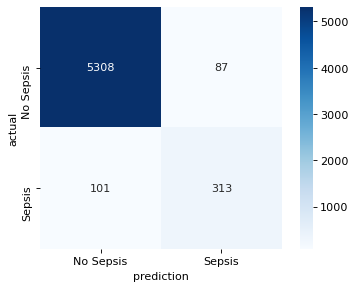

In [23]:
make_confusion_matrix(rf)

In [24]:
from sklearn.metrics import make_scorer
# creating a new scoring metric that uses beta = 2
f_beta_2 = make_scorer(fbeta_score, beta=2)

In [25]:
n_estimators = [x for x in range(50, 201, 10)]
bootstrap = [True, False]
max_depth = [x for x in range(1,11,1)]
max_depth.append(None)

In [26]:
n_estimators

[50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]

In [27]:
random_grid = {'n_estimators':n_estimators, 
              'max_depth':max_depth,
              'bootstrap':bootstrap}

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                              n_iter = 60, cv = 5, verbose=2, n_jobs=-1, scoring=f_beta_2,
                              error_score='raise')

In [28]:
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=RandomForestClassifier(n_estimators=130),
                   n_iter=60, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, None],
                                        'n_estimators': [50, 60, 70, 80, 90,
                                                         100, 110, 120, 130,
                                                         140, 150, 160, 170,
                                                         180, 190, 200]},
                   scoring=make_scorer(fbeta_score, beta=2), verbose=2)

In [29]:
rf_random.best_params_

{'n_estimators': 130, 'max_depth': None, 'bootstrap': False}

In [30]:
from sklearn.metrics import classification_report

In [31]:
feature_importance_df = pd.DataFrame({'importance':rf.feature_importances_}, index=X_val.columns).sort_values(by='importance', ascending=False).reset_index().rename(columns={'index':'features'})

In [32]:
feature_importance_df

,features,importance
0,ICULOS,0.220546
1,BUN,0.079091
2,Hgb,0.064216
3,Platelets,0.055547
4,Creatinine,0.053813
5,Hct,0.050467
6,Magnesium,0.044273
7,WBC,0.043738
8,Calcium,0.033611
9,Temp,0.028592


Text(0.5, 1.0, 'Feature Importances')

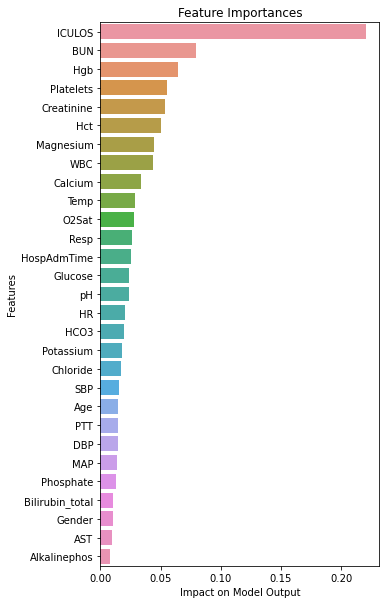

In [54]:
from matplotlib import pyplot
fig,ax = pyplot.subplots(figsize=(5,10))

sns.barplot(y=feature_importance_df['features'], x=feature_importance_df['importance'])
plt.xlabel('Impact on Model Output')
plt.ylabel('Features')
plt.title('Feature Importances')


In [55]:
X_rand_sample = X.sample(n=10)

In [35]:
type(X_rand_sample)

pandas.core.frame.DataFrame

In [36]:
list(X_rand_sample.index)

[33084, 3890, 7969, 33343, 14753, 28069, 7866, 16699, 31311, 23182]

In [37]:
[sepsis_df['isSepsis'][x] for x in list(X_rand_sample.index)]

[0, 0, 0, 0, 0, 1, 0, 0, 0, 1]

In [42]:
actuals_df = pd.DataFrame([sepsis_df['isSepsis'][x] for x in list(X_rand_sample.index)])
actuals_df.columns = ['Actuals']
actuals_df

,Actuals
0,0
1,0
2,0
3,0
4,0
5,1
6,0
7,0
8,0
9,1


In [43]:
rand_sample = X.sample(n=10)

preds = list(rf.predict(rand_sample))

indexes = list(rand_sample.index)

actuals = [sepsis_df['isSepsis'][x] for x in list(rand_sample.index)]

In [44]:
comparison_df = pd.DataFrame(
    {'index':indexes,
     'predicted': preds,
     'actual': actuals,
    })
comparison_df = comparison_df.set_index('index')

In [45]:
comparison_df

,predicted,actual
index,,
34460,1,1
30467,0,0
33204,0,0
27759,0,0
3341,1,1
9448,0,0
11581,0,0
24323,0,0
31324,0,0


In [46]:
pd.concat([rand_sample, comparison_df],axis=1)

,Age,ICULOS,HospAdmTime,Gender,HR,MAP,O2Sat,SBP,Resp,Glucose,...,Chloride,Temp,HCO3,PTT,AST,Bilirubin_total,Alkalinephos,pH,predicted,actual
34460,100.00,254,-8.34,0,81.0,72.00,91.0,101.0,28.0,122.0,...,106.0,36.80,24.0,30.7,32.0,0.8,72.0,7.39,1,1
30467,52.00,13,-3.22,1,85.0,82.00,97.0,108.0,17.0,231.5,...,106.0,36.80,24.0,30.7,24.0,0.8,127.0,7.39,0,0
33204,54.00,45,-1.93,1,60.5,80.00,96.0,80.0,16.0,210.0,...,106.0,36.80,24.0,30.7,9.0,0.8,104.0,7.39,0,0
27759,61.00,10,-244.44,0,89.0,72.00,95.0,97.0,24.0,116.0,...,106.0,37.10,24.0,30.7,32.0,0.8,72.0,7.39,0,0
3341,85.73,119,-251.49,1,81.0,70.00,90.0,122.0,20.0,146.0,...,102.0,36.80,27.0,53.6,32.0,0.8,72.0,7.44,1,1
9448,54.55,8,-68.11,1,97.0,81.00,98.0,140.0,14.0,93.0,...,108.0,36.78,25.0,47.9,32.0,0.8,72.0,7.32,0,0
11581,37.80,19,0.00,1,106.0,66.67,94.0,98.0,20.0,145.0,...,107.0,37.44,21.0,30.7,32.0,0.8,72.0,7.39,0,0
24323,65.00,9,-74.99,0,102.0,80.00,100.0,126.0,18.0,153.5,...,106.0,38.00,24.0,30.7,32.0,0.8,72.0,7.39,0,0
31324,71.00,8,-10.38,0,50.0,118.00,98.0,165.0,18.0,138.0,...,106.0,36.80,24.0,30.7,32.0,0.8,72.0,7.39,0,0
25287,80.00,28,-6.80,1,76.0,71.00,99.0,98.0,15.0,104.0,...,106.0,36.80,24.0,30.7,32.0,0.8,72.0,7.39,0,0


In [47]:
def model_results(X):
    rand_sample = X.sample(n=10)

    preds = list(rf.predict(rand_sample))

    indexes = list(rand_sample.index)

    actuals = [sepsis_df['isSepsis'][x] for x in list(rand_sample.index)]
    
    comparison_df = pd.DataFrame(
    {'index':indexes,
     'predicted': preds,
     'actual': actuals,
    })
    
    comparison_df = comparison_df.set_index('index')
    result_df = pd.concat([rand_sample, comparison_df],axis=1)
    
    return result_df

In [51]:
model_results(X)

,Age,ICULOS,HospAdmTime,Gender,HR,MAP,O2Sat,SBP,Resp,Glucose,...,Chloride,Temp,HCO3,PTT,AST,Bilirubin_total,Alkalinephos,pH,predicted,actual
32552,49.00,11,-73.91,1,105.5,72.5,100.0,94.0,18.0,136.5,...,107.0,35.60,24.0,30.7,48.0,1.3,29.0,7.34,0,0
238,55.69,8,-9.28,1,66.0,65.0,93.0,104.0,13.0,83.0,...,115.0,36.80,22.0,108.8,32.0,0.8,72.0,7.39,0,0
35153,72.00,2,-40.42,0,68.0,96.0,100.0,145.0,14.5,138.0,...,106.0,36.80,24.0,30.7,32.0,0.8,72.0,7.39,0,0
28273,46.00,14,-195.39,1,102.0,93.0,96.0,106.0,15.0,96.0,...,106.0,36.80,24.0,30.7,32.0,0.8,72.0,7.39,0,0
18094,32.31,25,-0.01,1,105.5,79.0,94.5,140.0,30.5,122.0,...,106.0,38.83,24.0,30.7,32.0,0.8,72.0,7.35,1,1
35703,57.00,12,-3.54,0,65.0,105.0,96.0,127.0,18.0,122.0,...,106.0,36.50,24.0,30.7,32.0,0.8,72.0,7.39,0,0
21353,68.00,25,-93.49,1,94.0,98.0,95.0,156.0,16.0,88.0,...,106.0,36.80,24.0,30.7,32.0,0.8,72.0,7.39,0,0
23926,30.00,36,-170.79,0,74.0,59.0,93.0,106.0,12.0,89.0,...,106.0,36.60,24.0,30.7,46.0,0.5,44.0,7.39,0,0
5386,84.86,40,-46.44,1,99.0,73.0,94.0,96.0,17.0,132.0,...,101.0,36.80,25.0,28.7,32.0,0.8,72.0,7.42,0,0
25190,64.00,22,-2.47,1,74.0,92.0,97.0,136.0,19.0,131.0,...,106.0,36.80,24.0,30.7,32.0,0.8,72.0,7.39,0,0


In [52]:
sepsis_df['isSepsis'][14868]

0